## SVM Implementation on scaled reduced dataset with SVD

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Set random seed for reproductibility

In [2]:
seed = 23

Read clean (scaled data)

In [3]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

Read Train Data

In [4]:
X_train= pd.read_csv('../../DimensionalityReductionData/X_train_SVD.csv')
X_train.head()

,Dimension 1,Dimension 2
0,1.103460,0.072267
1,1.461354,-0.592586
2,1.647283,0.088656
3,1.676719,-0.541218
4,1.570116,-0.572993


Read Test Data

In [5]:
X_test = pd.read_csv('../../DimensionalityReductionData/X_test_SVD.csv')
X_test.head()

,Dimension 1,Dimension 2
0,1.220573,0.206269
1,1.250327,-0.570413
2,1.368459,-0.546002
3,1.277790,0.761160
4,1.636357,0.070829


Do Train-Test Split to define y_train, y_test (both are raings)
!!!! IMPORTANT use random_state as defined in Dimension Reduction DATA SPLIT!!!!

In [6]:
y_train, y_test = train_test_split(df_scaled['averageRating'], test_size=0.2, random_state=42)

Now everything is defined (X_train, X_test, y_train, y_test)

Save and print metrics

In [7]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None, zero_division=0)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

In [8]:
model = SVC(random_state=seed)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))

print("F1 score:", f1_score(y_test, predictions, average=None))

Accuracy: 0.6042638241172552
F1 score: [0.55704698 0.64238411]


## Grid Search CV - 1

In [9]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}

model = SVC(random_state=seed)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("The parameters with the highest score: ", grid_search.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
The parameters with the highest score:  {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


In [10]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Show top 10 parameters for this model
minimalistic_results = cv_results_df[['params', 'mean_test_score']]
sorted_results = minimalistic_results.sort_values(by='mean_test_score', ascending=False)

print(sorted_results.head(10))

                                            params  mean_test_score
28    {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}         0.596335
24   {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}         0.596335
16    {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}         0.596334
20     {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}         0.594585
8      {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}         0.588837
0    {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}         0.588338
4     {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}         0.588171
12      {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}         0.587671
14     {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}         0.580341
2   {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}         0.579758


Metrics for SVC-SVD-GS-CV1:
Accuracy: 0.6106
Weighted F1: 0.6073
Weighted Precision: 0.6178
Weighted Recall: 0.6106
Macro-Averaged Precision: 0.6169
Macro-Averaged Recall: 0.6130
F1: [0.57690916 0.63930886]
Precision: [0.65114379 0.58267717]
classification report
              precision    recall  f1-score   support

     Class 0       0.65      0.52      0.58      1539
     Class 1       0.58      0.71      0.64      1463

    accuracy                           0.61      3002
   macro avg       0.62      0.61      0.61      3002
weighted avg       0.62      0.61      0.61      3002

Confusion Matrix


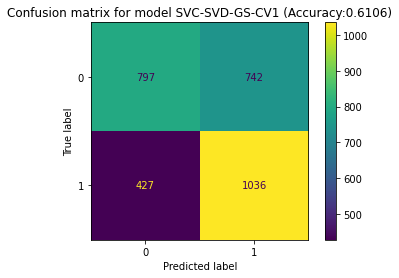

In [11]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
_ = calculate_metrics('SVC-SVD-GS-CV1', y_test, predictions)

In [12]:
# Predicting using other alternatives of fine-tuning from top 10 performances
other_alternatives = []
# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = SVC(random_state=seed, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)

  chosen_accuracy = accuracy_score(y_test, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)
  other_alternatives.append((chosen_accuracy,params))


Parameters from place:  0   {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.6105929380413058
Parameters from place:  1   {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.6135909393737509
Parameters from place:  2   {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.6112591605596269
Parameters from place:  3   {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.6072618254497002
Parameters from place:  4   {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.6042638241172552
Parameters from place:  5   {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.5972684876748834
Parameters from place:  6   {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.5969353764157228
Parameters from place:  7   {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.5969353764157228
Parameters

In [13]:
# get best from top 10
best_tuple = max(other_alternatives, key=lambda x: x[0])

In [14]:
print("Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances")
print(best_tuple[0])
print(best_tuple[1])

Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances
0.6135909393737509
{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


Classification report of best model from alternatives of fine tuning

In [15]:
model = SVC(random_state=seed, **best_tuple[1])
model.fit(X_train, y_train)

predictions = model.predict(X_test)
current_accuracy = accuracy_score(y_test, predictions)

classification_report(y_test, predictions, zero_division=0)


'              precision    recall  f1-score   support\n\n           0       0.65      0.52      0.58      1539\n           1       0.59      0.71      0.64      1463\n\n    accuracy                           0.61      3002\n   macro avg       0.62      0.62      0.61      3002\nweighted avg       0.62      0.61      0.61      3002\n'

Metrics for SVC-SVD-alternatives:
Accuracy: 0.6136
Weighted F1: 0.6104
Weighted Precision: 0.6208
Weighted Recall: 0.6136
Macro-Averaged Precision: 0.6199
Macro-Averaged Recall: 0.6160
F1: [0.58062184 0.64175417]
Precision: [0.65444173 0.58535211]
classification report
              precision    recall  f1-score   support

     Class 0       0.65      0.52      0.58      1539
     Class 1       0.59      0.71      0.64      1463

    accuracy                           0.61      3002
   macro avg       0.62      0.62      0.61      3002
weighted avg       0.62      0.61      0.61      3002

Confusion Matrix


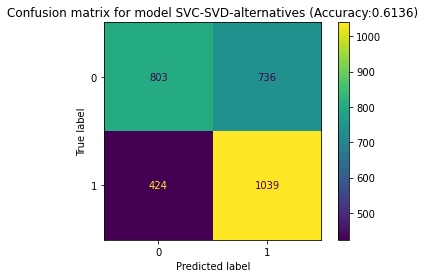

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
SVC-SVD-alternatives,0.613591,0.610414,0.620771,0.613591,0.619897,0.615976,[0.58062184 0.64175417],[0.65444173 0.58535211]


In [16]:
calculate_metrics('SVC-SVD-alternatives', y_test, predictions)